In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(affycoretools)
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(ggpubr)
library(fgsea)
library(clusterProfiler)
library(org.Hs.eg.db)
library(CMScaller)
library(RColorBrewer)
require(dplyr)
require(stringr)

Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

In [2]:
MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v3.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))
rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID
MM_cell_line = MM_cell_line[,-1]
MM_cell_line = MM_cell_line[,-1]
MM_patients = MM_patients[,-1]

In [3]:
subtype.info = data.frame(fread("2020-sup-tables2 (2).csv"))
colnames(subtype.info) = c("probeset", "gene_name", "chrom_map_pos", "SAM.score", "Subgroup", "adj")
keep_stinf = subtype.info$adj %in% "noid"
keep_stinf = !keep_stinf
subtype.info = subtype.info[keep_stinf,]
symbols = (subtype.info[,2])
test_df = as.data.frame(as.matrix(mapIds(org.Hs.eg.db, symbols, 'ENSEMBL', 'SYMBOL')))
subtype.info$gene_id = test_df[,1]
keepinpat =  subtype.info$gene_id %in% rownames(MM_patients)
subtype.info = subtype.info[keepinpat,]

'select()' returned 1:many mapping between keys and columns


In [4]:
subgroup2 = (str_replace_all(subtype.info$Subgroup, 'HP', 'HY'))
subtype.info$Subgroup = subgroup2

In [5]:
# MM_patients_new = filter(MM_patient_ids, str_extract(MM_patient_ids[,1], "_[0-9]_") == "_1_")


In [6]:
templates = subtype.info[, c("gene_id", "Subgroup")]
colnames(templates) = c("probe", "class")
templates$class = as.factor(templates$class)

Warning message:
"templates$probe coerced to character"

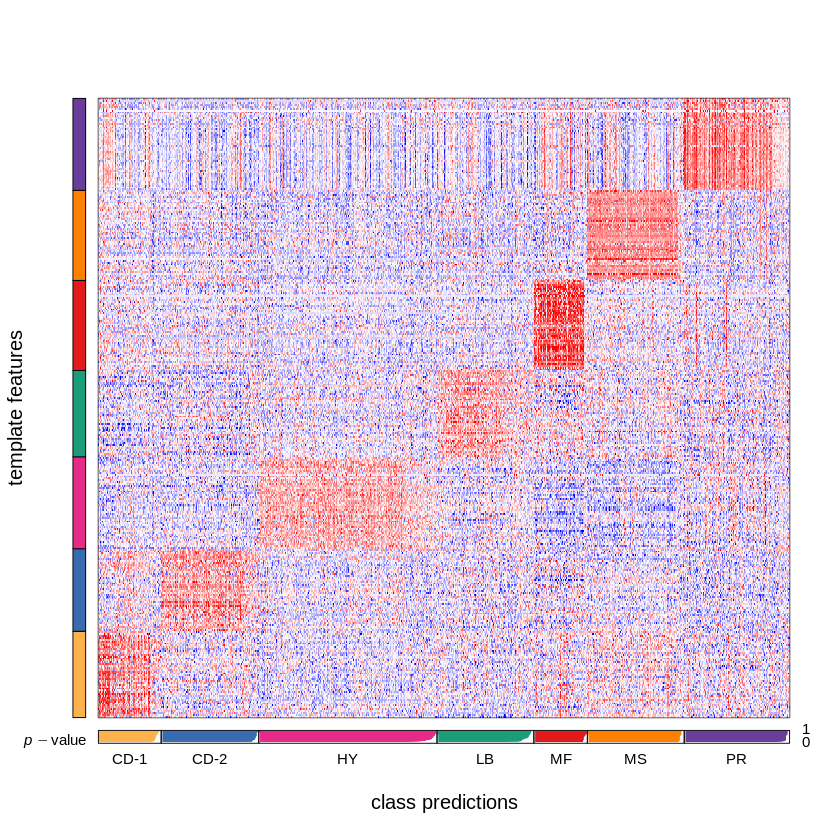

In [7]:
ematadj <- ematAdjust(MM_patients, normMethod = "quantile")
ntp.res = ntp(ematadj, templates, nPerm = 1000, distance = "cosine", 
              nCores = 4, seed = 1, verbose = getOption("verbose"), doPlot = T)

In [8]:
pat_names_1114 = data.frame(fread("pat_names_1114.csv"))
pat_names_1114 = pat_names_1114[-1,-1]

pat_names_1416 = data.frame(fread("pat_names_1416.csv"))
pat_names_1416 = pat_names_1416[-1,-1]

pat_names_1420 = data.frame(fread("pat_names_1420.csv"))
pat_names_1420 = pat_names_1420[-1,-1]

pat_names_414 = data.frame(fread("pat_names_414.csv"))
pat_names_414 = pat_names_414[-1,-1]

In [9]:
emat.sorted.pred = (ematadj[,rownames(ntp.res[order(ntp.res$prediction),])])

In [10]:
x = c()

pat_names = colnames(emat.sorted.pred)

for(pat in pat_names){
    if (pat %in% (pat_names_1114)){
        x = append(x, 't(11;14)')
    }
    else if (pat %in% (pat_names_1416)){
        x = append(x, 't(14;16)')
    }
    else if (pat %in% (pat_names_414)){
        x = append(x, 't(4;14)')
    }
    else if (pat %in% (pat_names_1420)){
        x = append(x, 't(14;20)')
    }
    else{
        x = append(x, 'Not Annotated')
    }
}

x = as.data.frame(x)
rownames(x) = colnames(emat.sorted.pred)

x1 = c("blue", "green", "orange", "magenta", "white")
names(x1) = c("t(11;14)", "t(14;16)", "t(4;14)", "t(14;20)", "Not Annotated")

pred1 = c("blue", "cyan", "magenta", "yellow", "green", "orange", "olivedrab3")
names(pred1) = c("CD-1", "CD-2", "HY", "LB", "MF", "MS", "PR")

temp1 = c("blue", "cyan", "magenta", "yellow", "green", "orange", "olivedrab3")
names(temp1) = c("CD-1", "CD-2", "HY", "LB", "MF", "MS", "PR")

FDR1 = c("blue", "red")
names(FDR1) = c("<= 0.05", "> 0.05")

anoc = list(Translocations = x1, prediction = pred1, templates = temp1, FDR = FDR1)

In [11]:
colnames(x) = 'Translocations'

In [12]:
ntp.res.sorted = (ntp.res[order(ntp.res$prediction),])
x$prediction = ntp.res.sorted$prediction

In [13]:
templates = (templates[order(templates$class),])

In [14]:
emat.sorted.pred.probe = (emat.sorted.pred[as.vector(templates$probe),])

In [15]:
FDR = c()

pat_names = colnames(emat.sorted.pred.probe)

for(pat in pat_names){
    if (ntp.res.sorted[pat, 10] <= 0.05){
        FDR = append(FDR, '<= 0.05')
    }
    else{
        FDR = append(FDR, '> 0.05')
    }
}

In [16]:
x$FDR = FDR

In [17]:
rownames(templates) = c(1:length(templates[,1]))
rownames(emat.sorted.pred.probe) = c(1:length(templates[,1]))
templates = as.data.frame(templates[,-1])
colnames(templates) = "templates"

In [18]:
paletteLength <- 24
myColor <- colorRampPalette(c("blue", "white", "red"))(paletteLength)
mybreaks = c(-6,-5, -4, -3, -2, -1.5, -1.25, -1, -0.75, -0.5, -0.25, -0.1, 
             0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 3, 4, 5, 6)

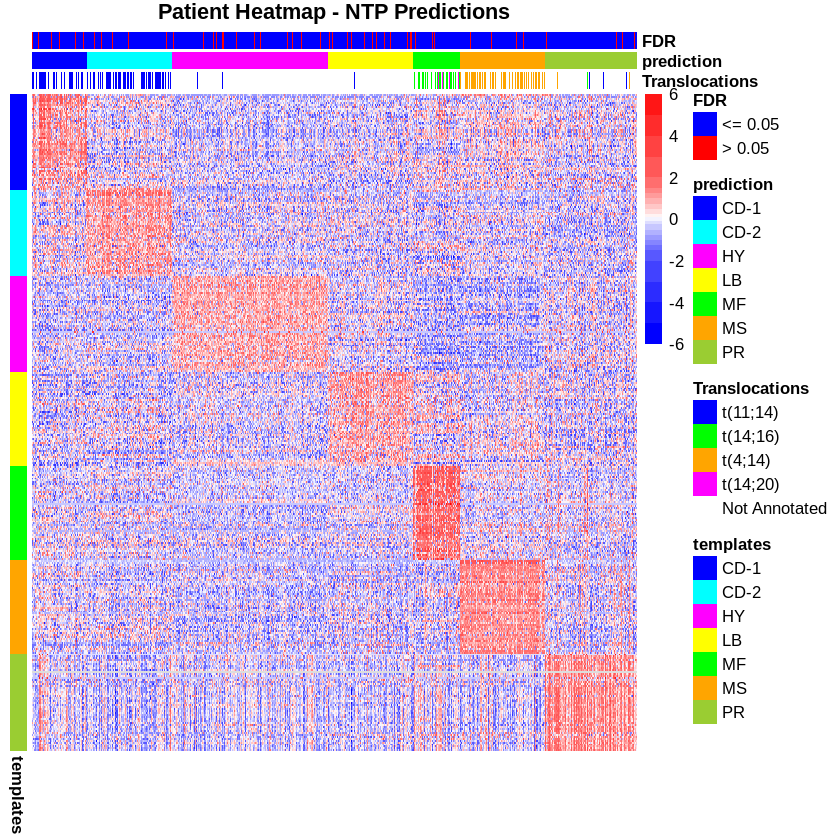

In [19]:
pheatmap(emat.sorted.pred.probe, annotation_col = x, annotation_row = templates, 
         color = myColor, breaks = mybreaks,
         annotation_colors = anoc, treeheight_row = 0,
         cluster_rows = FALSE, cluster_cols = FALSE,
         show_rownames = FALSE, show_colnames = FALSE, 
         main = 'Patient Heatmap - NTP Predictions')

In [ ]:
x2 = x

In [20]:
cell_names_1114 = data.frame(fread("cell_names_1114.csv"))
cell_names_1114 = cell_names_1114[-1,-1]

cell_names_1416 = data.frame(fread("cell_names_1416.csv"))
cell_names_1416 = cell_names_1416[-1,-1]

cell_names_1420 = data.frame(fread("cell_names_1420.csv"))
cell_names_1420 = cell_names_1420[-1,-1]

cell_names_414 = data.frame(fread("cell_names_414.csv"))
cell_names_414 = cell_names_414[-1,-1]

In [21]:
subtype.info = data.frame(fread("2020-sup-tables2 (2).csv"))
colnames(subtype.info) = c("probeset", "gene_name", "chrom_map_pos", "SAM.score", "Subgroup", "adj")
keep_stinf = subtype.info$adj %in% "noid"
keep_stinf = !keep_stinf
subtype.info = subtype.info[keep_stinf,]
symbols = (subtype.info[,2])
test_df = as.data.frame(as.matrix(mapIds(org.Hs.eg.db, symbols, 'ENSEMBL', 'SYMBOL')))
subtype.info$gene_id = test_df[,1]
keepincells =  subtype.info$gene_id %in% rownames(MM_cell_line)
subtype.info = subtype.info[keepincells,]

'select()' returned 1:many mapping between keys and columns


In [22]:
subgroup2 = (str_replace_all(subtype.info$Subgroup, 'HP', 'HY'))
subtype.info$Subgroup = subgroup2

In [23]:
templates = subtype.info[, c("gene_id", "Subgroup")]
colnames(templates) = c("probe", "class")
templates$class = as.factor(templates$class)

Warning message:
"templates$probe coerced to character"

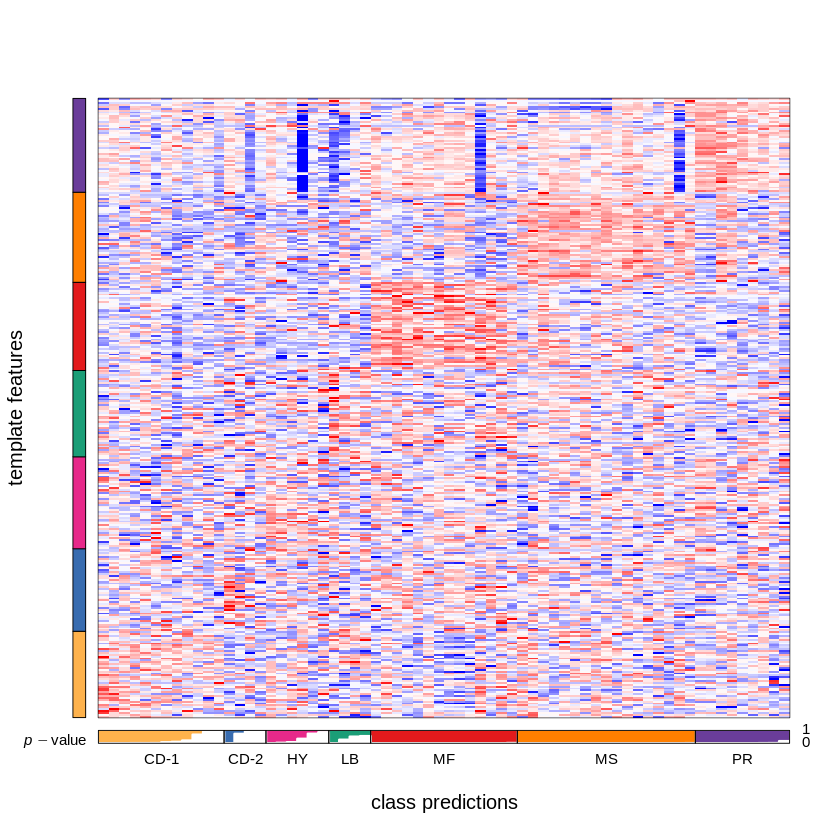

In [24]:
ematadj <- ematAdjust(MM_cell_line, normMethod = "quantile")
ntp.res = ntp(ematadj, templates, nPerm = 1000, distance = "cosine", 
              nCores = 4, seed = 1, verbose = getOption("verbose"), doPlot = T)

In [25]:
emat.sorted.pred = (ematadj[,rownames(ntp.res[order(ntp.res$prediction),])])

In [26]:
x = c()

pat_names = colnames(emat.sorted.pred)

for(pat in pat_names){
    if (pat %in% (cell_names_1114)){
        x = append(x, 't(11;14)')
    }
    else if (pat %in% (cell_names_1416)){
        x = append(x, 't(14;16)')
    }
    else if (pat %in% (cell_names_414)){
        x = append(x, 't(4;14)')
    }
    else if (pat %in% (cell_names_1420)){
        x = append(x, 't(14;20)')
    }
    else{
        x = append(x, 'Not Annotated')
    }
}

x = as.data.frame(x)
rownames(x) = colnames(emat.sorted.pred)

x1 = c("blue", "green", "orange", "magenta", "white")
names(x1) = c("t(11;14)", "t(14;16)", "t(4;14)", "t(14;20)", "Not Annotated")

pred1 = c("blue", "cyan", "magenta", "yellow", "green", "orange", "olivedrab3")
names(pred1) = c("CD-1", "CD-2", "HY", "LB", "MF", "MS", "PR")

temp1 = c("blue", "cyan", "magenta", "yellow", "green", "orange", "olivedrab3")
names(temp1) = c("CD-1", "CD-2", "HY", "LB", "MF", "MS", "PR")

FDR1 = c("blue", "red")
names(FDR1) = c("<= 0.05", "> 0.05")

anoc = list(Translocations = x1, prediction = pred1, templates = temp1, FDR = FDR1)

In [27]:
colnames(x) = 'Translocations'

In [28]:
ntp.res.sorted = (ntp.res[order(ntp.res$prediction),])
x$prediction = ntp.res.sorted$prediction

In [29]:
templates = (templates[order(templates$class),])

In [30]:
emat.sorted.pred.probe = (emat.sorted.pred[as.vector(templates$probe),])

In [31]:
FDR = c()

pat_names = colnames(emat.sorted.pred.probe)

for(pat in pat_names){
    if (ntp.res.sorted[pat, 10] <= 0.05){
        FDR = append(FDR, '<= 0.05')
    }
    else{
        FDR = append(FDR, '> 0.05')
    }
}

In [32]:
x$FDR = FDR

In [33]:
rownames(templates) = c(1:length(templates[,1]))
rownames(emat.sorted.pred.probe) = c(1:length(templates[,1]))
templates = as.data.frame(templates[,-1])
colnames(templates) = "templates"

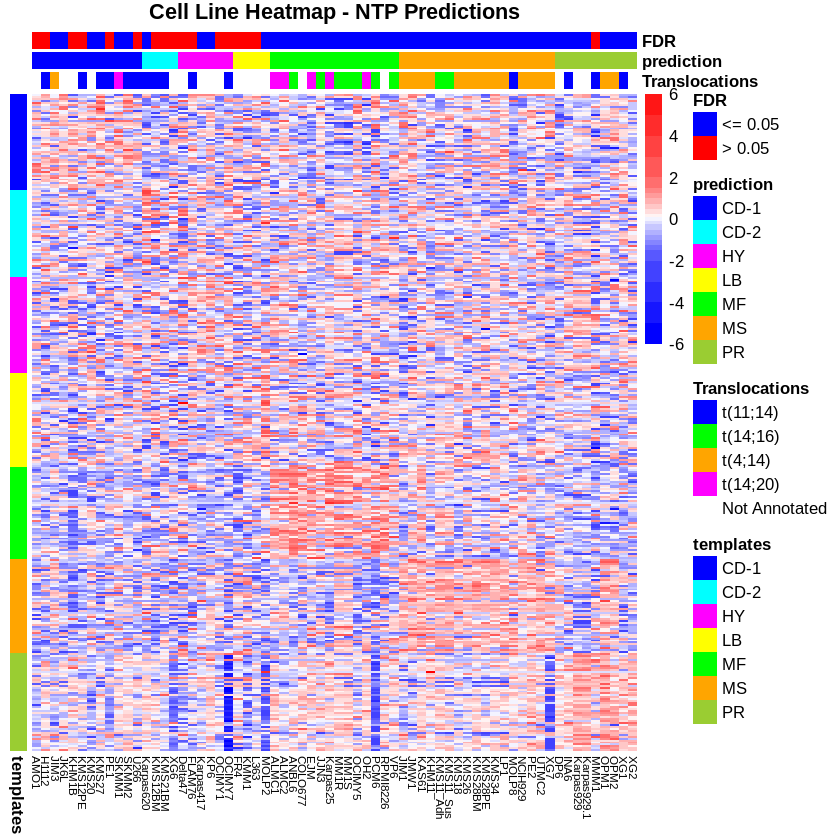

In [34]:
pheatmap(emat.sorted.pred.probe, annotation_col = x, annotation_row = templates, color = myColor, 
         breaks = mybreaks, fontsize_col = 7, show_colnames = TRUE, annotation_colors = anoc, 
         cluster_rows = FALSE, cluster_cols = FALSE, show_rownames = FALSE, 
         main = 'Cell Line Heatmap - NTP Predictions')

In [35]:
top5kgenes = data.frame(fread("fivekgenes.csv"))
top5kgenes = top5kgenes[-1,-1]

In [36]:
MM_cell_line_hm = MM_cell_line[top5kgenes,]
ematadj <- ematAdjust(MM_cell_line_hm, normMethod = "quantile")

In [37]:
y = c()

gene_names = rownames(ematadj)

for(gene in gene_names){
    if (gene %in% as.vector(subtype.info$gene_id)){
        temp = as.vector(subtype.info$gene_id) %in% gene
        temp2 = subtype.info[temp, ]
        y = append(y, temp2[1, 5])
    }
    else{
        y = append(y, 'Not Annotated')
    }
}

In [38]:
y = as.data.frame(y)
rownames(y) = rownames(ematadj)

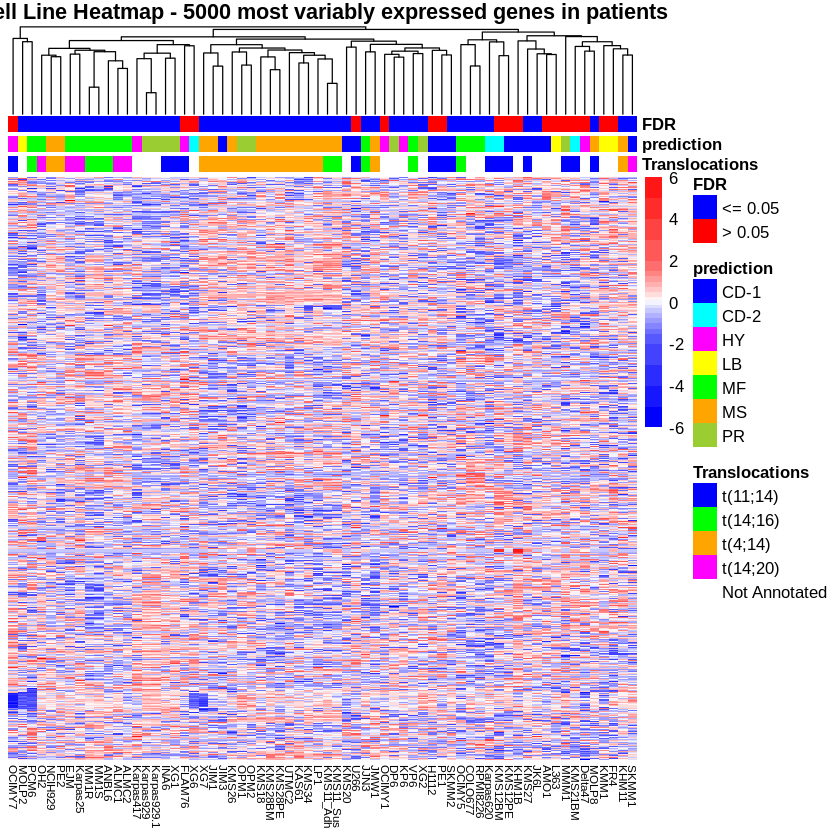

In [42]:
pheatmap(ematadj, annotation_col = x, treeheight_row = 0,#annotation_row = y, 
         color = myColor, breaks = mybreaks, fontsize_col = 7, 
         show_colnames = TRUE, annotation_colors = anoc, show_rownames = FALSE,
         main = 'Cell Line Heatmap - 5000 most variably expressed genes in patients')